# Basics with numerical time-series

* Find this notebook at `EpyNN/nnlive/dummy_time/train.ipynb`.
* Regular python code at `EpyNN/nnlive/dummy_time/train.py`.

In this notebook we will review:

* Handling univariate time series data to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Recurrent Neural Network (RNN) for binary classification task.
* Overfitting of the model to the training data and impact of Dropout regularization

Please see the following if you get lost:

* [Fully Connected (Dense)](../../Dense.html)
* [Recurrent Neural Network (RNN)](../../RNN.html)
* [Dropout - Regularization](../../Dropout.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, sample features is an univariate time series which may consist of only white noise (negative) or white noise supplemented with a pure sine-wave of random frequency (positive). 

The goal of the game is to train a Neural Network which may be able to detect if samples features contain or not a true signal.

In [1]:
# EpyNN/nnlive/dummy_time/train.ipynb
# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.dropout.models import Dropout
from nnlibs.embedding.models import Embedding
from nnlibs.flatten.models import Flatten
from nnlibs.rnn.models import RNN
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=1024)

Let's control what we retrieved.

In [2]:
print(X_features[0].shape)
print(X_features[0])

(128, 1)
[[-0.35376783]
 [-0.17895082]
 [-0.29156932]
 ...
 [-0.25263271]
 [-0.74700792]
 [-0.16726332]]


This is called an *univariate time series* because it contains a single measurement per time step. Not that we retrieved data with sampling rate equal to 128 for a then duration of 1 second.

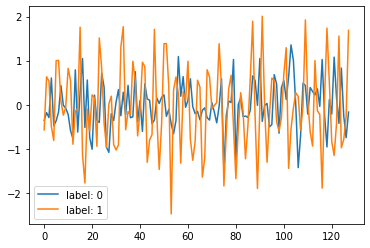

In [3]:
plt.plot(X_features[0], label='label: %s' % Y_label[0])
plt.plot(X_features[1], label='label: %s' % Y_label[1])
plt.legend()
plt.show()
plt.close()

While sample features corresponding to ``label: 0`` do not contain a true signal, sample features corresponding to ``label: 1`` do contain a true signal of random frequency.

## Feed-Forward (FF)

Feed-Forward Neural Network are advantageous compared to other architectures because they are relatively fast to train, and most often less sensitive to parameters of training, also called *hyperparameters*. Therefore, it is most commonly a first choice when dealing with a new problem and prior to further insights.

### Embedding

In EpyNN, sample features (X_features) and label (Y_label) are passed to the corresponding arguments value when instantiating the *embedding* or *input* layer. It is required to use this layer in EpyNN, which is then always the first layer of the network architecture. The layer consist of a simple forward pass but contains several routines to prepare data according to user choices.

In [4]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

Herein, we instructed to the class constructor ``Embedding`` to one-hot encode the set of sample label ``Y_encode=True``. We also instructed to split data in order to build a training set contraining ``2/3`` of the whole set while the testing set will contain ``1/3``.

The training procedure is exclusively driven by the training data. However, one may judge how general the model can be by comparing metrics with evaluation on the testing set.

### Flatten-(Dense)n

As introduced before, samples features are univariate time series and as such the set of sample features has 3 dimensions.

In [5]:
print(embedding.dtrain.X.shape)    # (m, s, v)

(683, 128, 1)


It contains 683 samples (m), each described by a sequence of 128 features (s) containing 1 element (v).

However, the fully-connected or *dense* layer can only process bi-dimensionnal input arrays. That is the reason why we need to invoke a *flatten* layer in between the *embedding* and *dense* layer.

In [6]:
flatten = Flatten()

# Original shape (m, s, v)
print(embedding.dtrain.X.shape)

# Flatten on forward pass (m, s * v)
print (flatten.forward(embedding.dtrain.X).shape)

# Reverse on backward pass (m, s, v)
print (flatten.backward(flatten.forward(embedding.dtrain.X)).shape)

(683, 128, 1)
(683, 128)
(683, 128, 1)


In words, the *flatten* layer is an adapter.

Let's now build the network architecture.

In [7]:
name = 'Flatten_Dense-64-relu_Dense-2-softmax'

# Tune defaults learning rate from 0.1 to 0.005
se_hPars['learning_rate'] = 0.005

flatten = Flatten()

hidden_dense = Dense(64, relu)

dense = Dense(2, softmax)

layers = [embedding, flatten, hidden_dense, dense]

model = EpyNN(layers=layers, name=name)

The network - or model - architecture is sucessively composed of the mandatory *embedding* input layer, one *hidden_dense* layer with 64 nodes and *ReLU* activation function and finally an output *dense* layer with 2 nodes - because we have two distinct one-hot encoded labels - and a *softmax* activation function.

We now initialize the model and instruct to use a *Mean Square Error* cost function with network *seeding* for reproducibility and we provide our custom hyperparameters.

In [8]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

The initialize method performs a dry epoch which includes all steps but not parameters update.

We can now proceed with the training.

In [9]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 1.0 Cost: 0.00204 - TIME: 19.37s RATE: 5.04e+02e/s TTC: 0sm

+-------+----------+----------+-------+----------+-------+-------+--------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                    Experiment                    |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                  |
+-------+----------+----------+-------+----------+-------+-------+--------------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.495 |  0.504   | 0.279 | 0.277 | 1630335866_Flatten_Dense-64-relu_Dense-2-softmax |
|  10   | 5.00e-03 | 5.00e-03 | 0.902 |  0.815   | 0.087 | 0.129 | 1630335866_Flatten_Dense-64-relu_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 | 0.991 |  0.874   | 0.029 | 0.097 | 1630335866_Flatten_Dense-64-relu_Dense-2-softmax |
|  30   | 5.00e-03 | 5.00e-03 | 0.997 |  0.877   | 0.015 | 0.089 | 1630335866_Fl

We can observe on the logs that an accuracy of 1 was reached after 40 iterations on th training set with a cost near zero. By contrast, we can observe that - although good - the metrics and cost computed on the testing set ran behind from the early epochs of the regression.

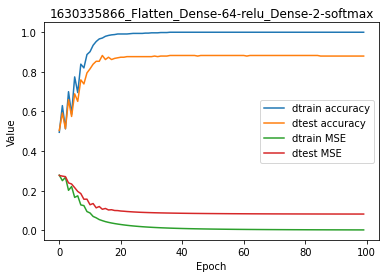

In [10]:
model.plot(path=False)

When plotting the accuracy and cost for training and testing sets, these differences are even more obvious.

This is called *overfitting* of the model to the training data. In words, the model represents very well - and even exactly - the data from which it was trained, but lacks such performance on independant data.

There are many way to limit such overfitting when designing or training a Neural Network. Herein we are going to experiment the *dropout* regularization method to see how it can impact such unwanted overfitting behavior.

### Flatten-(Dense)n with Dropout

You can follow [this link]() for details on the *dropout* layer.

Briefly, the *dropout* regularization layer randomly subsamples the output of the previous layer and forward the product to the next layer. By introducing such instability in the network, the layer reduces the thinning capacity of the network which may be of interest to prevent from overfitting, which happens when the model is too closely related to the training data.

In EpyNN, the class constructor ``Dropout()`` takes a single argument ``keep_prob`` which represents the probability of one element in the input array to be preserved in the output array.

For instance.

In [11]:
test_array = np.random.standard_normal((5, 5))

D1 = (np.random.uniform(0, 1, test_array.shape) < 1)
D05 = (np.random.uniform(0, 1, test_array.shape) < 0.5)
D0 = (np.random.uniform(0, 1, test_array.shape) < 0)

print(test_array)
print(test_array * D1)    # keep_prob = 1 - No dropout
print(test_array * D05)   # keep_prob = 0.5 - Common value
print(test_array * D0)    # keep_prob = 0 - Output is null

[[ 2.87969013  0.21353864  0.54048673 -1.12987712  0.16667646]
 [-0.06599243 -0.78487781 -0.90093635 -0.05976155 -0.16413189]
 [-0.3344821   0.16040274 -0.30192393  0.0302875   0.69051686]
 [ 0.21288486  0.46747628 -0.05089657 -1.25717835  0.18107881]
 [-0.51598842 -0.1427927   0.23779259 -1.33228867 -1.11153375]]
[[ 2.87969013  0.21353864  0.54048673 -1.12987712  0.16667646]
 [-0.06599243 -0.78487781 -0.90093635 -0.05976155 -0.16413189]
 [-0.3344821   0.16040274 -0.30192393  0.0302875   0.69051686]
 [ 0.21288486  0.46747628 -0.05089657 -1.25717835  0.18107881]
 [-0.51598842 -0.1427927   0.23779259 -1.33228867 -1.11153375]]
[[ 2.87969013  0.21353864  0.         -0.          0.16667646]
 [-0.06599243 -0.78487781 -0.         -0.         -0.        ]
 [-0.3344821   0.16040274 -0.30192393  0.0302875   0.69051686]
 [ 0.          0.46747628 -0.05089657 -1.25717835  0.        ]
 [-0.51598842 -0.1427927   0.23779259 -0.         -0.        ]]
[[ 0.  0.  0. -0.  0.]
 [-0. -0. -0. -0. -0.]
 [-0. 

Usually, values for ``keep_prob`` are within 0.5-1.

Let's build the same Feed-Forward network than above but with implementation of two *dropout* layers.

In [12]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a first *dropout1* between the *flatten* and *hidden_dense* layer as well as a second one between *hidden_dense* and *dense*.

Note the ``keep_prob`` values are different for the two *dropout* layers. We will preserve 0.8 of the input for the first, only 0.5 for the second. Those settings are quite empirical, better just to test and see.

Initialize with same settings as is the no-dropout setup.

In [13]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

You can see the *dropout* layers did appear in the check. Let's proceed with training.

In [14]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 0.968 Cost: 0.03121 - TIME: 21.34s RATE: 5.39e+02e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                               Experiment                               |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                        |
+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.562 |  0.507   | 0.255 | 0.285 | 1630335885_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  10   | 5.00e-03 | 5.00e-03 | 0.717 |  0.695   | 0.174 | 0.195 | 1630335885_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 | 0.874 |  0.839   | 0.104 | 0.125 

It is clear that the delta between training and testing set is much reduced now, both for accuracy metrics and MSE cost.

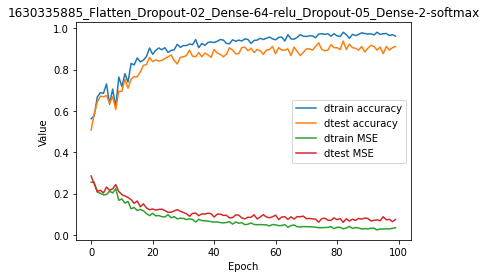

In [15]:
model.plot(path=False)

In brief, think about using *dropout* layers to reduce overfitting, alone or in combination with other methods.

## Recurrent Neural Network (RNN)

When dealing with any sort of sequential data, it is often suggested to use recurrent architectures because they can process three-dimensional input arrays and take advantage of the *sequential* nature of sample features.

### Embedding

Let's embedd our data again, using the same settings as before, and proceed with a little refresh.

In [16]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

print(embedding.dtrain.X.shape)        # (m, s, v)
print(embedding.dtrain.X[:, 0].shape)  # Input shape at sequence step 0

(683, 128, 1)
(683, 1)


We have 683 samples (m) with sequential features of length 128 (s) which represents an univariate time series (v).

We recalled before that sample features may be white noise, or white noise combined with a pure sine-wave of random frequency. While there is no expected **correlation through time** within the white noise, we expect a **periodic pattern** to repeat in the case where a pure since-wave is also present in sample features.

Recurrent layer are said to have some internal memory of such periodic patterns because:

* X
* Y
* Z

Said differently, the output of one recurrent cell does not only depend of the input at a given sequence step.

### RNN-Dense

Below we will instantiate a simple *RNN* layer composed of 10 cells which forward the last (10th) hidden state to the output *dense* layer. 

In [17]:
name = 'RNN-10_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01
se_hPars['softmax_temperature'] = 5

rnn = RNN(10)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

Note the difference compared to previous examples with pure Feed-Forward networks:

* **Learning rate:** X.
* **Softmax temperature:** Y.
* **Flatten layer:** It is absent. This is because RNN returns the last hidden state of shape (10,). The flatten operation is therefore unnecessary. Not that RNN in EpyNN may return all hidden states sequences (``RNN(10, sequences=True)``) which then would require the use of a flatten layer because the shape would be (128, 10).

Let's give a try to this RNN-based network.

In [18]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Start training.

In [19]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 0/0 - Accuracy: 0.616 Cost: 0.23482 - TIME: 32.37s RATE: 3.17e+02e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                Experiment                 |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                           |
+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 | 0.485 |  0.510   | 0.252 | 0.250 | 1630335906_RNN-10_Flatten_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 | 0.489 |  0.534   | 0.250 | 0.250 | 1630335906_RNN-10_Flatten_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 | 0.505 |  0.569   | 0.250 | 0.249 | 1630335906_RNN-10_Flatten_Dense-2-softmax |
|  30   | 1.00e-02 | 1.00e-02 | 0.505 |  0.560   | 0.249 | 0.248 | 1630335906_RNN-10_Flatten_Dense-2-softmax |
|  40   | 1.00e-0

We observe that although converging, it is slow and we get overfitting from the first epochs.

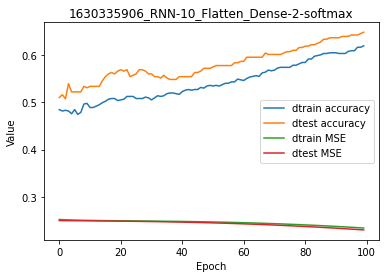

In [20]:
model.plot(path=False)

It is clear that this model would need more training epochs to converge, but this would not fix the overfitting problem.

### RNN-Dense with SGD

In the above-example we used Gradient Descent (GD) optimization, meaning that:

* All training examples are in a single batch.
* There is a single weight update by training epoch.

Below we set ``batch_size`` to ``32`` to used Stochastic Gradient Descent (SGD), meaning that:

* All training examples are divided into batches of size 32, yielding N_SAMPLES // 32 batches.
* There is as many weight update by training epochs than training batches.

In [21]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We use the same network than before.

In [22]:
name = 'RNN-10_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01
se_hPars['softmax_temperature'] = 5

rnn = RNN(10)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

We initialize and train the nework.

In [23]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 20/20 - Accuracy: 1.0 Cost: 0.00151 - TIME: 48.64s RATE: 9.16e+03e/s TTC: 0s0m

+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                Experiment                 |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                           |
+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 | 0.504 |  0.543   | 0.252 | 0.249 | 1630335939_RNN-10_Flatten_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 | 0.587 |  0.610   | 0.239 | 0.237 | 1630335939_RNN-10_Flatten_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 | 0.792 |  0.801   | 0.196 | 0.191 | 1630335939_RNN-10_Flatten_Dense-2-softmax |
|  30   | 1.00e-02 | 1.00e-02 | 0.851 |  0.848   | 0.139 | 0.138 | 1630335939_RNN-10_Flatten_Dense-2-softmax |
|  40   | 1.00e

For the same number of training epochs, accuracy is much higher.

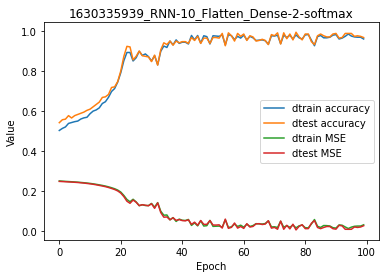

In [24]:
model.plot(path=False)

And there is no overfitting, this is an excellent model.

## Write, Read & Predict

In [25]:
### Write/read model

model.write()

model = read_model()


### Predict

X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features)

for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

Make: /media/synthase/beta/EpyNN/nnlive/dummy_time/models/1630335939_RNN-10_Flatten_Dense-2-softmax.pickle
0 1 [0.07426968 0.92573032]
1 1 [0.06888625 0.93111375]
2 0 [0.9550402 0.0449598]
3 1 [0.05746133 0.94253867]
4 0 [0.96124307 0.03875693]
5 0 [0.9721737 0.0278263]
6 0 [0.96822956 0.03177044]
7 1 [0.08186878 0.91813122]
8 1 [0.05380397 0.94619603]
9 1 [0.02270502 0.97729498]
